# COMPUTATIONAL ASSIGNMENT 2
### Andreas Stapnes og Inga Konow

## The trebuchet

TASK 1.
Express the velocities of the projectile and counterweight as functions of the angles $\psi, \theta$ and their time derivatives $\dot{\psi},\dot{\theta}$. Calculate the Lagrangian and the equations of motion.

The velocities of the projectile and the counterweight is given by the time derivative of their position r.

$$
\dot{r_1}=
\begin{bmatrix}
l_1\dot{\theta}cos(\theta)\\
l_1\dot{\theta}sin(\theta)
\end{bmatrix}
$$

$$
\dot{r_{2b}}=
\begin{bmatrix}
-l_2\dot{\theta}cos(\theta)-l_4(\dot{\psi}-\dot{\theta})cos(\psi-\theta)\\
-l_2\dot{\theta}sin(\theta)+l_4(\dot{\psi}-\dot{\theta})cos(\psi-\theta)
\end{bmatrix}

$$

Height for the counter weight, $m_1$:
$-l_1cos(\theta)+l_3$

Height for the projectile, $m_2$:
$l_2cos(\theta)+l_3-l_4cos(\psi-\theta)$

We have the Lagrangian for the system given by:

$$
L(\theta,\dot{\theta}, \psi, \dot{\psi})=\sum_i T_i-V_i \\
=\sum_i \frac12m_iv_1^2 - m_igh = \sum_i \frac12m_i\dot{r_i^2}-m_igh\\
$$

If we use the calculated time derivative of $r$, $\dot{r}$, and put it into the equation together with the height of the different masses, we get the following result:

$$
L=\frac12(m_1l_1^2+m_2l_2^2)\dot{\theta}^2-gl_3(m_1+m_2)\\
+g(m_1l_1-m_2l_2)cos(\theta)+\frac12m_2l_4^2(\dot{\psi}-\dot{\theta})^2\\
+m_2l_2l_4\dot{\theta}(\dot{\psi}-\dot{\theta})cos(\psi)+gm_2l_4cos(\psi-\theta)
$$

Applying the Euler-Lagrange equations for $\theta$ and $\psi$ we get:

$$
\frac{\partial L}{\partial \theta}-\frac{\partial}{\partial t}(\frac{\partial L}{\partial \dot{\theta}})= 0
$$

$$
\frac{\partial L}{\partial \psi}-\frac{\partial}{\partial t}(\frac{\partial L}{\partial \dot{\psi}})= 0
$$

This gives us the following results:

$$
(-l_1^2m_1-l_2^2m_2+2l_2l_4m_2cos(\psi)-l_4^2m_2)\ddot{\theta}-l_4m_2(l_2cos(\psi)-l_4)\ddot{\psi}\\
=gm_1l_1sin(\theta)-gm_2\big(l_2sin(\theta)+l_4sin(\psi-\theta))-l_2l_4m_2(\dot{\psi}-2\dot{\theta})sin(\psi)\dot{\psi}
$$

and 

$$
-l_4m_2(l_2cos(\psi)-l_4)\ddot{\theta}-l_4^2m_2\ddot{\psi}=l_4m_2\big(gsin(\psi-\theta)-l_2sin(\psi)\dot{\theta}^2),
$$

which can be expressed as matrix (6) in the assignment.

We then want to use Runge-Kutta 4th order algorithm to solve the equations of motion. We are using the parameters and initial conditions stated in the table in the assignment. We are plotting $\theta, \dot{\theta}, \psi$ and $\dot{\psi}$ as functions of t.

### Methods from assignment 1
Firstly we will include the methods implemented in our previous assignment, as these will be used later in this assignment.

In [1]:
from __future__ import annotations
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum


#Constants and parameters:
a = 6.5e-3  # constant in adiabatic approximation?
T0 = 288
y_0 = 1e4  # k_B*T/mg
alfa = 2.5  # constant for air?
drag_coefficient = 4e-5  # per air particle mass, in m^-1#!/usr/bin/python
g = 9.81

y0 = 1e4

# Sistnevnte er en bash-kommando for aa kjore resten av filen i python
# om filen kjores direkte fra kommandolinjen
from typing import Callable, Tuple, NamedTuple, Union, List


def RK4(f: Callable[[any,float], float], y: any, t: float, dt: float) -> Tuple[any, float]:
	k_1 = f(y, t)
	k_2 = f(y+k_1*dt/2, t+dt/2)
	k_3 = f(y+k_2*dt/2, t+dt/2)
	k_4 = f(y+k_3*dt, t+dt)
	y_next = y + 1/6*(k_1+2*k_2+2*k_3+k_4)*dt
	return y_next, t+dt


def Euler(f: Callable[[any, float], float], y:any, t:float, dt:float) -> Tuple[any, float]:
	k_1 = f(y, t)
	y_next = y + k_1*dt
	return y_next, t+dt


def crossing(ph_1: CartesianPhase, ph_2: CartesianPhase, y_crossing: float) -> Union[float, bool]:
	if not ((ph_1.y < y_crossing) ^ (ph_2.y < y_crossing)):
		return False
	r = -ph_1.y/ph_2.y
	return (r*ph_2.x + ph_1.x)/(r+1)


	

class CartesianPhase(NamedTuple):
	x: float
	y: float
	v_x: float
	v_y: float

	def speed(self):
		return np.sqrt(self.v_x**2+self.v_y**2)

	def __add__(self, rhs: CartesianPhase):
		return CartesianPhase(*[l+r for l,r in zip(self, rhs)])

	def __radd__(self, lhs: CartesianPhase):
		return self + lhs

	def __mul__(self, rhs:float):
		return CartesianPhase(*[l*rhs for l in self])

	def __rmul__(self, lhs:float):
		return self*lhs

	def __truediv__(self, rhs:float):
		return self*(1/rhs)


class Drag_type(Enum):
	NODRAG = "No drag"
	UNIFORM = "Uniform drag"
	ISOTHERMAL = "Isothermal drag"
	ADIABATIC = "Adiabatic drag"



def phase_derivative_nodrag(ph: CartesianPhase, t: float):
	'''Basic derivative-equation'''
	return CartesianPhase(ph.v_x, ph.v_y, 0, -g)

def phase_derivative_drag(ph: CartesianPhase, t: float, drag_multiplier=1):
	'''Derivative-equation including drag'''
	#Friction points in negative-v-direction with size B*v^2, where
	# B/m = drag_coefficient, so the acceleration caused
	#  by friction is given by drag_coefficient * v * (-v-vector)
	drag_factor = drag_coefficient*ph.speed()*drag_multiplier  #
	return CartesianPhase(ph.v_x, ph.v_y, -drag_factor*ph.v_x, -drag_factor*ph.v_y-g)

def phase_derivative_isothermal_drag(ph: CartesianPhase, t: float):
	drag_multiplier = np.exp(-ph.y/y0)
	return phase_derivative_drag(ph, t, drag_multiplier)

def phase_derivative_uniform_drag(ph: CartesianPhase, t: float):
	return phase_derivative_drag(ph, t)

def phase_derivative_adiabatic_drag(ph: CartesianPhase, t: float):
	drag_multiplier = (1-6.5e-3*ph.y/T0)**alfa
	return phase_derivative_drag(ph, t, drag_multiplier)

def phase_prime_method(drag_type:Drag_type=Drag_type.NODRAG):
	if drag_type is Drag_type.NODRAG: return phase_derivative_nodrag
	elif drag_type is Drag_type.UNIFORM: return phase_derivative_uniform_drag
	elif drag_type is Drag_type.ISOTHERMAL: return phase_derivative_isothermal_drag
	elif drag_type is Drag_type.ADIABATIC: return phase_derivative_adiabatic_drag
	else:
		raise Exception("How did you get here?")


class SYS:
	phases: List[CartesianPhase]
	crash_distance: Union[None, float]
	def __init__(self, init_phase:CartesianPhase, init_time:float=0,
				 drag_type:Drag_type=Drag_type.NODRAG):
		self.phases = [init_phase]
		self.times = [init_time]
		self.crash_distance = None

		self.prop_method = phase_prime_method(drag_type)

	def propagate_until_crash(self, y_floor:float, dt=1):
		while True:
			current_phase = self.phases[-1]
			t = self.times[-1]
			next_phase, t_next = RK4(self.prop_method, current_phase, t, dt)
			if (x_cross := crossing(current_phase, next_phase, y_floor)) is False:
				self.phases.append(next_phase)
				self.times.append(t_next)
				continue
			self.crash_distance = x_cross
			break


def polar_to_cartesian(abs_val: float, theta: float):
	return abs_val*np.cos(theta), abs_val*np.sin(theta)



Next we will implement various methods for computing the dynamical development of the ***Trebuchet***. The foundation of our implementations is a class named Phase. Phase mainly consists of values and time-derivatives for the angles $\theta$ and $\phi$ as described in the assignment. It also includes methods for computing the cartesian velocities of the masses $m_1$ and $m_2$, along with the appropriate position-vectors.  
  
During the initialization of a Phase-object, one must specify timesteps for dynamic development *dt*. The overloaded method for integer-addition of phase-objects with iterate the development of the given phase. 

In [2]:
from __future__ import annotations
from typing import NamedTuple, overload, Union

m_1_global = 2e3
m_2_global = 15
l_1_global = 1.2
l_2_global = 5.7
l_3_global = 3.2
l_4_global = 5

def a_mat(theta: float, theta_prime: float, psi: float, psi_prime: float,
          m_1: float = m_1_global, m_2: float = m_2_global, l_1: float = l_1_global, l_2: float = l_2_global,
          l_3: float = l_3_global, l_4: float = l_4_global) -> np.ndarray:
    return np.array([
        -l_1**2*m_1 - l_2**2*m_2 + 2*l_2*l_4*m_2*np.cos(psi) - l_4**2*m_2,
        -l_4*m_2*(l_2*np.cos(psi)-l_4),
        -l_4*m_2*(l_2*np.cos(psi)-l_4),
        -l_4**2*m_2
    ]).reshape((2, 2))



def a_inverse(theta: float, theta_prime: float, psi: float, psi_prime: float,
          m_1: float = m_1_global, m_2: float = m_2_global, l_1: float = l_1_global, l_2: float = l_2_global,
          l_3: float = l_3_global, l_4: float = l_4_global):
    return np.linalg.inv(a_mat(theta, theta_prime, psi, psi_prime, m_1, m_2, l_1, l_2, l_3, l_4))

def b_vec(theta: float, theta_prime: float, psi: float, psi_prime: float,
          m_1: float = m_1_global, m_2: float = m_2_global, l_1: float = l_1_global, l_2: float = l_2_global,
          l_3: float = l_3_global, l_4: float = l_4_global):
    return np.array([
        g*m_1*l_1*np.sin(theta) - g*m_2*(l_2*np.sin(theta) + l_4*np.sin(psi-theta)) - l_2*l_4*m_2*(psi_prime-2*theta_prime)*np.sin(psi)*psi_prime,
        l_4*m_2*(g*np.sin(psi-theta)-l_2*np.sin(psi)*theta_prime**2)
    ])


def function_for_RK(phase: Phase, t:float):
    theta = phase.theta
    psi = phase.psi
    theta_prime = phase.theta_prime
    psi_prime = phase.psi_prime
    theta_double_prime, psi_double_prime = a_inverse(theta, theta_prime, psi, psi_prime) @ b_vec(theta, theta_prime, psi, psi_prime)
    return Phase(theta_prime, theta_double_prime, psi_prime, psi_double_prime)




class Phase(NamedTuple):
    theta: float
    theta_prime: float
    psi: float
    psi_prime: float

    dt: Union[float, None] = None

    @overload
    def __add__(self, iterations: int): ...
    @overload
    def __add__(self, rhs: Phase): ...

    def __add__(self, rhs: Union[int, Phase]):
        if type(rhs) is int:
            calculated_phase = self
            for enum in range(rhs):
                calculated_phase, t = calculated_phase.make_propagated(self.dt)
            return calculated_phase
        elif type(rhs) is Phase:
            if self.dt is not None:
                dt = self.dt
                if rhs.dt is not None:
                    if rhs.dt != self.dt: raise Exception("The phases have non-matching dt-values!")
            elif rhs.dt is not None:
                dt = rhs.dt
            else:
                dt = None
            return Phase(self.theta + rhs.theta,
                         self.theta_prime + rhs.theta_prime,
                         self.psi + rhs.psi,
                         self.psi_prime + rhs.psi_prime,
                         dt)
        else:
            raise Exception("Invalid addition of states")

    def make_propagated(self, timestep: float = None):
        if timestep is None: timestep = self.dt
        return RK4(function_for_RK, self, 0, timestep)

    def __mul__(self, rhs:float):
        return Phase(self.theta * rhs, self.theta_prime*rhs,
                     self.psi*rhs, self.psi_prime*rhs, self.dt)

    def __rmul__(self, lhs:float):
        return self*lhs

    def __truediv__(self, rhs:float):
        return self*(1/rhs)

    def m1_velocity(self):
        return l_1_global*np.array([np.cos(self.theta), np.sin(self.theta)])

    def m2_velocity(self):
        return np.array([-l_2_global*np.cos(self.theta)*self.theta_prime - l_4_global*np.cos(self.psi-self.theta)*(self.psi_prime - self.theta_prime),
                         -l_2_global*np.sin(self.theta)*self.theta_prime + l_4_global*np.sin(self.psi-self.theta)*(self.psi_prime-self.theta_prime)])

    def m1_r(self):
        return np.array([l_1_global*np.sin(self.theta), -l_1_global*np.cos(self.theta) + l_3_global])

    def m2_r(self):
        return np.array([-l_2_global*np.sin(self.theta)-l_4_global*np.sin(self.psi-self.theta),
                         l_2_global*np.cos(self.theta) + l_3_global - l_4_global*np.cos(self.psi-self.theta)])

    def m2_cartesian_phase(self):
        return CartesianPhase(*self.m2_r(), *self.m2_velocity())

    def propagate_until_release(self, release_angle: float) -> Phase:
        local_phase = self
        while local_phase.theta > release_angle:
            #print(local_phase)
            local_phase = local_phase + 1
        return local_phase



# Task 2
We choose the initial conditions of the ***Trebuchet*** as stated in table 1 in the assignment.

We plot the system for the first 100 seconds


<ipython-input-3-faa2089a95d2>:45: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
<ipython-input-3-faa2089a95d2>:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


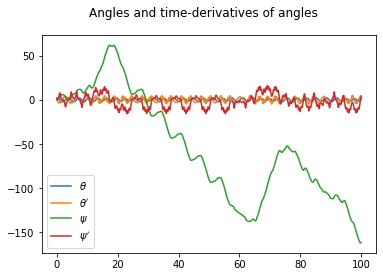

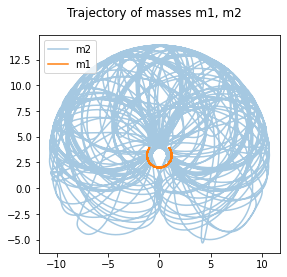

In [3]:
import matplotlib.pyplot as plt


maxtime = 100


if __name__ == "__main__":
    fig1, ax1 = plt.subplots(1,1)
    fig2, ax2 = plt.subplots(1,1)
    
    
    dt = 1e-2
    initial_phase = Phase(theta=0.7*np.pi, theta_prime=0, 
                         psi=0.2*np.pi, psi_prime=0, dt=dt)
    
    phase = initial_phase
    
    t = 0
    t_values = []
    phase_values = []
    while t < maxtime:
        phase_values.append(phase)
        t_values.append(t)
        phase += 1
        t += dt
    
    phase_array = np.array(phase_values).T
    ax1.plot(t_values, phase_array[0], label=r"$\theta$")
    ax1.plot(t_values, phase_array[1], label=r"$\theta'$")
    ax1.plot(t_values, phase_array[2], label=r"$\psi$")
    ax1.plot(t_values, phase_array[3], label=r"$\psi'$")
    
    m1_r_values = np.array([phase.m1_r() for phase in phase_values])
    m2_r_values = np.array([phase.m2_r() for phase in phase_values])
    ax2.plot(*m2_r_values.T, label="m2", alpha=0.4)
    ax2.plot(*m1_r_values.T, label="m1")
    
    ax2.legend()
    ax2.set_aspect("equal")
    
    ax1.legend()
    print(f"We plot the system for the first {maxtime} seconds")
    fig1.suptitle("Angles and time-derivatives of angles")
    fig2.suptitle(r"Trajectory of masses m1, m2")
    fig1.show()
    fig2.show()
    

m1 remains on a fixed circle centered at the tebuchet-centre, as expected. The movement of m2 is rather chaotic, but this is to be expected as it lies at the end of some double-pendulum-like construction.


# Task 3

When $\theta$ reaches $\theta_r=0.1\pi$, we use the velocity and firing angle as initial conditions for the equations of motion without air resistance from assignment 1.

In [15]:
if __name__ == "__main__":
    release_angle = 0.1*np.pi
    phase = initial_phase #Slik definert tidligere
    phase = phase.propagate_until_release(release_angle)
    cartesian_phase = phase.m2_cartesian_phase()
    x, y, vx, vy = cartesian_phase
    print(f"{x=:.3f}, {y=:.3f}, {vx=:.3f}, {vy=:.3f} at the time of release")
    

x=-6.540, y=10.031, vx=27.935, vy=48.538 at the time of release


Now we consider a range of release-angles between $0$ and $40^\circ$, and plot the resulting projectile-trajectories. 

<ipython-input-16-b46947bc3150>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


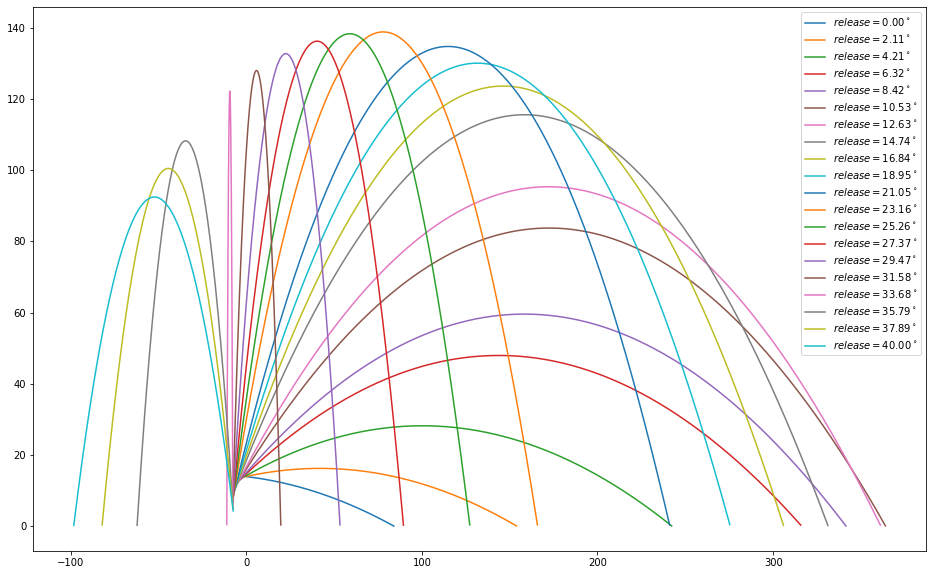

In [16]:
release_angles = np.linspace(0,40,20)*np.pi/180 

if __name__ == "__main__":
    fig, ax = plt.subplots(1,1, figsize=(16,10))
    for release_angle in release_angles:
        phase = initial_phase #Slik definert tidligere
        phase = phase.propagate_until_release(release_angle)
        cartesian_phase = phase.m2_cartesian_phase()
        x, y, vx, vy = cartesian_phase

        projectile_system = SYS(cartesian_phase)
        projectile_system.propagate_until_crash(y_floor=0, dt=1e-2)
        positionals = np.array(projectile_system.phases).T

        
        xs = []
        ax.plot(positionals[0], positionals[1], label=fr"$release={180/np.pi*release_angle:.2f}^\circ$")
    ax.legend()
    fig.show()

In order to get an estimate of where the Trebuchet starts to fire in the forward-direction, we plot the projectile-x-velocity as a function of release-angle.

************************************************************************************************************************************************************************************************************************************************************************************************************The projectile propagates in the forward direction for $\theta<31.71^\circ$


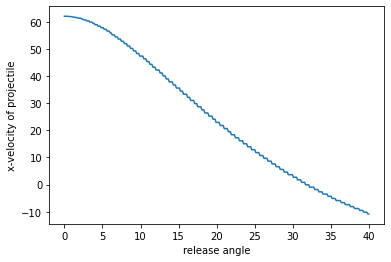

In [20]:
release_angles = np.linspace(0,40,300)*np.pi/180
if __name__ == "__main__":
    dt = 3e-3
    initial_phase = Phase(theta=0.7*np.pi, theta_prime=0, 
                         psi=0.2*np.pi, psi_prime=0, dt=dt)
    x_velocities = []
    for release_angle in release_angles:
        phase = initial_phase #Slik definert tidligere
        phase = phase.propagate_until_release(release_angle)
        cartesian_phase = phase.m2_cartesian_phase()
        x, y, vx, vy = cartesian_phase
        x_velocities.append(vx)
        print("*",end="")

    fig, ax = plt.subplots(1,1)
    ax.plot(release_angles*180/np.pi, x_velocities)
    ax.set_xlabel("release angle")
    ax.set_ylabel("x-velocity of projectile")
    for i in range(len(x_velocities)):
        if x_velocities[i] <0:
            break
    print("")
    print(fr"The projectile propagates in the forward direction for theta<{180/np.pi*release_angles[i]:.2f}*")
    

Now we do the same thing again for $\theta=0.9\pi$ and $\phi=0.4\pi$.

************************************************************************************************************************************************************************************************************************************************************************************************************
The projectile propagates in the forward direction for \theta<40.00*


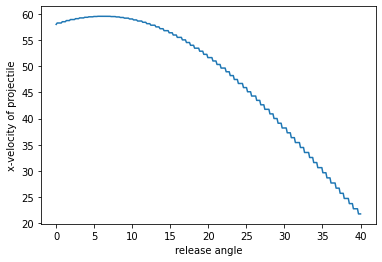

In [21]:
release_angles = np.linspace(0,40,300)*np.pi/180
if __name__ == "__main__":
    dt = 3e-3
    initial_phase = Phase(theta=0.9*np.pi, theta_prime=0, 
                         psi=0.4*np.pi, psi_prime=0, dt=dt)
    x_velocities = []
    for release_angle in release_angles:
        phase = initial_phase #Slik definert tidligere
        phase = phase.propagate_until_release(release_angle)
        cartesian_phase = phase.m2_cartesian_phase()
        x, y, vx, vy = cartesian_phase
        x_velocities.append(vx)
        print("*",end="")

    fig, ax = plt.subplots(1,1)
    ax.plot(release_angles*180/np.pi, x_velocities)
    ax.set_xlabel("release angle")
    ax.set_ylabel("x-velocity of projectile")
    for i in range(len(x_velocities)):
        if x_velocities[i] <0:
            break
    print("")
    print(fr"The projectile propagates in the forward direction for theta<{180/np.pi*release_angles[i]:.2f}*")
    

Now we set $\psi=0$ initially.

************************************************************************************************************************************************************************************************************************************************************************************************************
The projectile propagates in the forward direction for \theta<31.30*


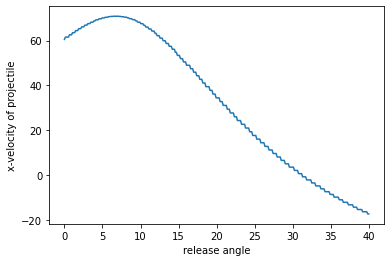

In [22]:
release_angles = np.linspace(0,40,300)*np.pi/180
if __name__ == "__main__":
    dt = 3e-3
    initial_phase = Phase(theta=0.9*np.pi, theta_prime=0, 
                         psi=0, psi_prime=0, dt=dt)
    x_velocities = []
    for release_angle in release_angles:
        phase = initial_phase #Slik definert tidligere
        phase = phase.propagate_until_release(release_angle)
        cartesian_phase = phase.m2_cartesian_phase()
        x, y, vx, vy = cartesian_phase
        x_velocities.append(vx)
        print("*",end="")

    fig, ax = plt.subplots(1,1)
    ax.plot(release_angles*180/np.pi, x_velocities)
    ax.set_xlabel("release angle")
    ax.set_ylabel("x-velocity of projectile")
    for i in range(len(x_velocities)):
        if x_velocities[i] <0:
            break
    print("")
    print(fr"The projectile propagates in the forward direction for theta < {180/np.pi*release_angles[i]:.2f}*")
    

# Why?

# Task 4
We choose initial conditions as in task 1

***************************************************************************************************

No handles with labels found to put in legend.
No handles with labels found to put in legend.


*

<ipython-input-27-b1a77a31b2f1>:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


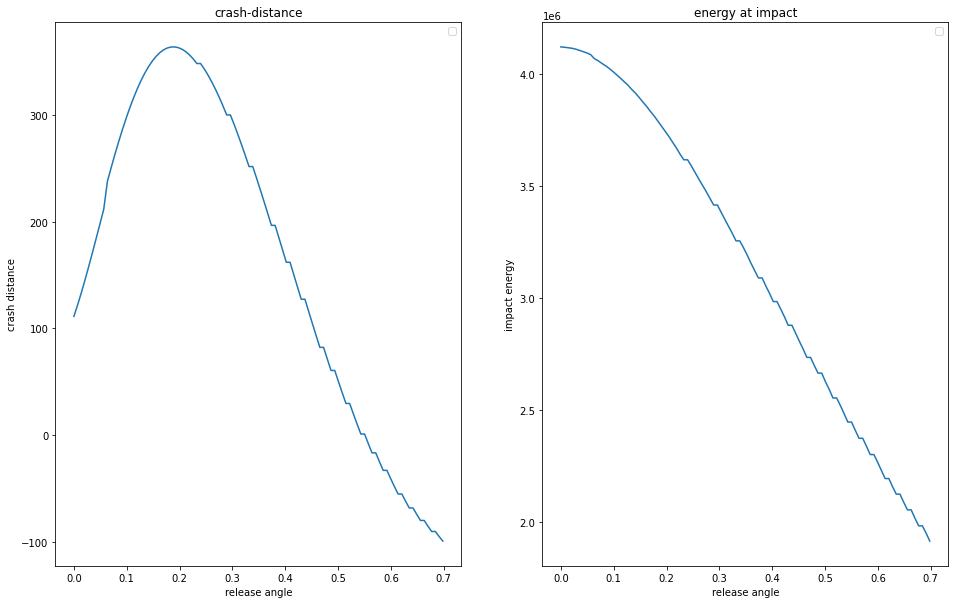

In [27]:
release_angles = np.linspace(0,40,100)*np.pi/180
if __name__ == "__main__":
    dt = 3e-3
    initial_phase = Phase(theta=0.7*np.pi, theta_prime=0, 
                         psi=0.2*np.pi, psi_prime=0, dt=dt)
    crash_distances = []
    crash_energies = []
    for release_angle in release_angles:
        phase = initial_phase #Slik definert tidligere
        phase = phase.propagate_until_release(release_angle)
        cartesian_phase = phase.m2_cartesian_phase()
        cartesian_system = SYS(cartesian_phase)
        cartesian_system.propagate_until_crash(y_floor=0, dt=dt)
        crash_distances.append(cartesian_system.crash_distance)
        last_phase = cartesian_system.phases[-1]
        crash_energies.append(1/2*m_1_global*last_phase.speed()**2)
        print("*",end="")
        

    fig, (ax_distance, ax_energy) = plt.subplots(1,2,figsize=(16,10))
    ax_distance.plot(release_angles, crash_distances)
    ax_energy.plot(release_angles, crash_energies)
    
    ax_distance.set_xlabel("release angle")
    ax_distance.set_ylabel("crash distance")
    ax_energy.set_xlabel("release angle")
    ax_energy.set_ylabel("impact energy")
    ax_energy.set_title("energy at impact")
    ax_distance.set_title("crash-distance")
    ax_distance.legend()
    ax_energy.legend()
    fig.show()